In [118]:
import cv2
import numpy as np

def detect_and_crop_subplots(image_path, size_threshold=0.1):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the original image for visualization
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Draw contours in green
    
    # Show contours
    cv2.imshow('Contours', contour_image)
    cv2.waitKey(0)
    
    cropped_images = []
    h_img, w_img = image.shape[:2]
    for contour in contours:
        # Get the bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # if w>20 or h>20:print(w,h)
        # Optionally filter contours based on size
        # if w > 100 and h > 100:  # Adjust thresholds as needed
        #     cropped = image[y+10:y + h-10, x+10:x + w-10]
        #     cropped_images.append(cropped)

        min_width = size_threshold * w_img
        min_height = size_threshold * h_img

        # Optionally filter contours based on size relative to the image size
        if w > min_width and h > min_height:  # Adjust thresholds based on image size
            cropped = image[y + 10:y + h - 10, x + 10:x + w - 10]
            cropped_images.append(cropped)
    
    cv2.destroyAllWindows()  # Close all OpenCV windows
    return cropped_images

# Example usage
# image_path = 'image copy 2.png'
# image_path = 'seizure_ex.png'
# image_path = 'image copy 3.png'
image_path='Screenshot from 2024-11-05 21-43-35.png'


cropped_images = detect_and_crop_subplots(image_path)

# Save cropped images
for i, img in enumerate(cropped_images):
    cv2.imwrite(f'cropped_subplot_{i + 1}.jpg', img)


In [119]:
# #if we are given image with axis written, we can extract the max y and x values so that we could later normalize
# import easyocr
# import cv2

# # Initialize the EasyOCR reader
# reader = easyocr.Reader(['en'])
# image_path = 'image copy 2.png'
# image = cv2.imread(image_path)
# results = reader.readtext(image)
# max_x = -1
# highest_y = 1000000
# x_range=None
# y_range=None
# for (bbox, text, prob) in results:
#     top_left_x, top_left_y = bbox[0]
#     bottom_right_x, bottom_right_y = bbox[2]
#     if bottom_right_x>max_x:
#         max_x=bottom_right_x
#         x_range=text

#     if top_left_y<highest_y:
#         highest_y=top_left_y
#         y_range=text

#     highest_y = min(highest_y, top_left_y)

# print("Max X (Rightmost):", x_range)
# print("Highest Y (Topmost):", y_range)


In [120]:
import cv2
import numpy as np
import pandas as pd
from scipy.spatial import distance

# Load the graph image
image = cv2.imread('Screenshot from 2024-11-03 16-27-33.png')

# image = cv2.imread('image.png')


image = cv2.imread('cropped_subplot_1.jpg')

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(gray, 0, 360)
# Apply a Hough Line Transform to detect the primary line
lines = cv2.HoughLinesP(edges, 1, np.pi / 45, threshold=10, minLineLength=10, maxLineGap=10)

# Store the points of the detected line
data_points = []
x_range=10

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Linearly interpolate points between (x1, y1) and (x2, y2) to sample evenly along the line
        num_samples = max(abs(x2 - x1), abs(y2 - y1))  # Choose a sampling rate based on distance
        # num_samples=x_range*500
        # num_samples=10000
        # x_values = np.linspace(x1, x2, num_samples)
        # y_values = np.linspace(y1, y2, num_samples)
        x_values=[x1,x2]
        y_values=[y1,y2]


        # Collect sampled points
        for x, y in zip(x_values, y_values):
            color = image[int(y), int(x)]  # Get color at each sampled point
            data_points.append({'position': (x, y), 'color': color})

# Filtering: Remove points that deviate significantly from the primary color
colors = np.array([point['color'] for point in data_points])
dominant_color = np.mean(colors, axis=0)
threshold_distance = 100

# Filter points based on color similarity to the dominant color
filtered_points = [
    point['position'] for point in data_points
    if np.linalg.norm(point['color'] - dominant_color) < threshold_distance
]
# filtered_points=data_points['position']

# Define graph dimensions and ranges for normalization (adjust to your specific graph)
graph_width, graph_height = image.shape[1], image.shape[0]

# x_range=250
# y_range=
# x_axis_range, y_axis_range = (0, int(x_range)), (-int(y_range), int(y_range))

# Normalize the filtered points
normalized_points = []
for point in filtered_points:
    # normalized_x = (point[0] / graph_width) * (x_axis_range[1] - x_axis_range[0]) + x_axis_range[0]
    normalized_x = (point[0] / graph_width) 
    # normalized_y = (1 - point[1] / graph_height) * (y_axis_range[1] - y_axis_range[0]) + y_axis_range[0]
    normalized_y = (1 - point[1] / graph_height)

    normalized_points.append((normalized_x, normalized_y))

# Save normalized points to a CSV file
df = pd.DataFrame(normalized_points, columns=['Normalized X', 'Normalized Y'])
df.to_csv('filtered_normalized_data_points.csv', index=False)

# Optional: Visualize the detected line on the original image
for point in filtered_points:
    cv2.circle(image, (int(point[0]), int(point[1])), 1, (0, 0, 255), -1)

cv2.imshow('Detected Line', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ WARN:0@5735.757] global loadsave.cpp:241 findDecoder imread_('Screenshot from 2024-11-03 16-27-33.png'): can't open/read file: check file path/integrity


In [121]:
# import cv2
# import numpy as np
# import pandas as pd

# # Load the graph image
# image = cv2.imread('cropped_subplot_1.jpg')

# if image is None:
#     raise ValueError("Image file not found. Please check the file path.")

# # Convert to grayscale for edge detection
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# edges = cv2.Canny(gray, 0, 360)

# # Apply a Hough Line Transform to detect lines
# lines = cv2.HoughLinesP(edges, 1, np.pi / 520, threshold=10, minLineLength=1, maxLineGap=5)

# # Calculate total line lengths to determine how many points to sample per line
# line_lengths = []
# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
#         line_lengths.append(line_length)
# else:
#     raise ValueError("No lines detected in the image.")

# # Total length of all lines
# total_length = sum(line_lengths)

# # Allocate points based on line lengths
# data_points = []
# points_remaining = 178
# num_lines = len(lines)

# for i in range(num_lines):
#     x1, y1, x2, y2 = lines[i][0]
    
#     # Calculate points for this line based on its proportion of the total length
#     if total_length > 0:
#         points_for_line = max(1, int((line_lengths[i] / total_length) * points_remaining))
#     else:
#         points_for_line = 1  # Default to at least one point if total_length is zero

#     # Adjust on the last line to ensure the total adds up to 178
#     if i == num_lines - 1:
#         points_for_line = points_remaining  # Allocate any remaining points to the last line

#     # Update remaining points
#     points_remaining -= points_for_line

#     # Sample points along the line
#     x_values = np.linspace(x1, x2, points_for_line)
#     y_values = np.linspace(y1, y2, points_for_line)

#     for x, y in zip(x_values, y_values):
#         data_points.append((x, y))

# # Normalize the sampled points
# graph_width, graph_height = image.shape[1], image.shape[0]
# normalized_points = [
#     ((x / graph_width), (1 - y / graph_height)) for x, y in data_points
# ]

# # Save normalized points to a CSV file
# df = pd.DataFrame(normalized_points, columns=['Normalized X', 'Normalized Y'])
# df.to_csv('filtered_normalized_data_points.csv', index=False)

# # Optional: Visualize the detected line and sampled points on the original image
# for point in data_points:
#     cv2.circle(image, (int(point[0]), int(point[1])), 1, (0, 0, 255), -1)

# cv2.imshow('Detected Line', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [122]:
import cv2
import numpy as np

# Load the graph image
image = cv2.imread('cropped_subplot_1.jpg')

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to smooth the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny Edge Detection with adjusted thresholds
edges = cv2.Canny(blurred, 30, 100)

# Optionally, you can create a color image to visualize the edges over the original image
# Create a colored edge image
colored_edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
colored_edges[edges > 0] = [0, 0, 255]  # Change edge pixels to red

# Show the edges
cv2.imshow('Edges', edges)
cv2.imshow('Colored Edges', colored_edges)

cv2.waitKey(0)
cv2.destroyAllWindows()


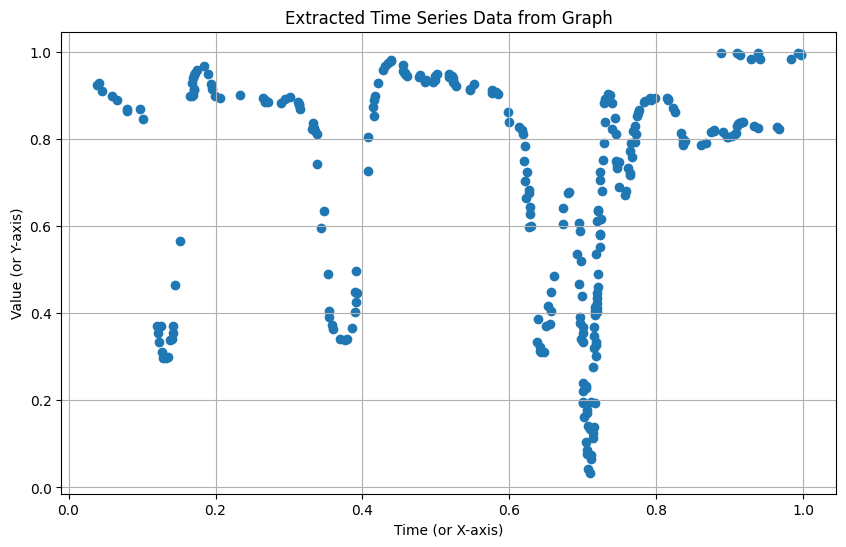

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the normalized data points from CSV
df = pd.read_csv('filtered_normalized_data_points.csv')

# Extract X and Y coordinates
x = df['Normalized X']
y = df['Normalized Y']

# Plot the points
plt.figure(figsize=(10, 6))
plt.scatter(x, y)

# Label the axes
plt.xlabel("Time (or X-axis)")
plt.ylabel("Value (or Y-axis)")
plt.title("Extracted Time Series Data from Graph")

# Show the plot
plt.grid(True)
plt.show()


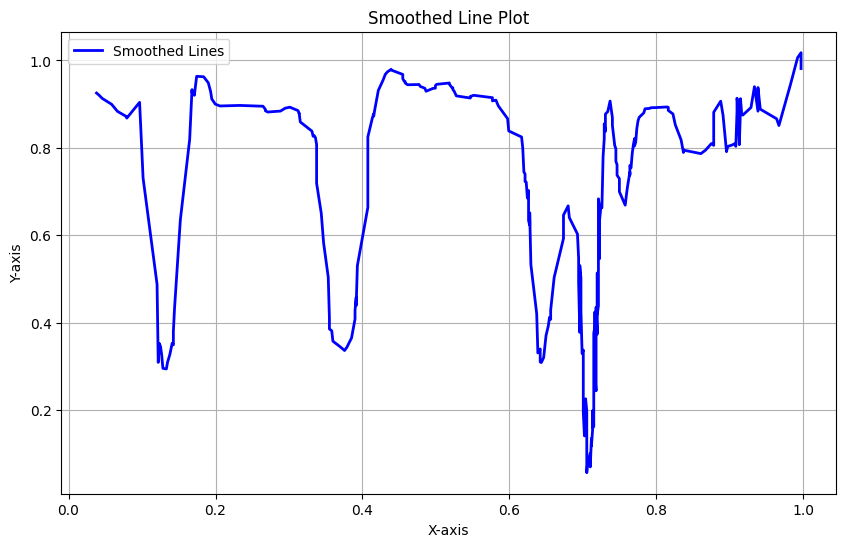

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Example: Assuming `lines` is a list of detected lines in the format [[x1, y1, x2, y2]]
# Extract points for plotting
all_x = []
all_y = []
    
# Convert to numpy arrays for easier manipulation
all_x = np.array(x)
all_y = np.array(y)

# Sort points if necessary (optional)
sorted_indices = np.argsort(all_x)
all_x = all_x[sorted_indices]
all_y = all_y[sorted_indices]

# Apply a Savitzky-Golay filter to smooth the y values
smoothed_y = savgol_filter(all_y, window_length=5, polyorder=2)  # Adjust parameters as needed

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(all_x, smoothed_y, color='blue', linewidth=2, label='Smoothed Lines')
# plt.scatter(all_x, all_y, color='red', s=10, label='Detected Points')  # Optional: Show original points
plt.title('Smoothed Line Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()
plt.show()


In [130]:
# import numpy as np
# import pandas as pd
# from scipy.signal import savgol_filter

# # Define the size for each row
row_size = 178

# Calculate the maximum number of complete rows
num_complete_rows = len(all_y) // row_size

# Truncate the smoothed_y array to fit complete rows
smoothed_y_truncated = all_y[:num_complete_rows * row_size]

# Reshape into a 2D array with each row having the specified size
reshaped_y = smoothed_y_truncated.reshape(-1, row_size)

# Create a DataFrame from the reshaped array
df_smoothed = pd.DataFrame(reshaped_y)

# Save the DataFrame to CSV
df_smoothed.to_csv('smoothed_values.csv', index=False, header=False)  # header=False to omit column headers if not needed

# Optionally, print the DataFrame to verify
print(df_smoothed)


        0         1         2         3        4         5         6    \
0  0.922518  0.927361  0.910412  0.898305  0.88862  0.864407  0.869249   

        7         8        9    ...       168       169       170       171  \
0  0.869249  0.845036  0.37046  ...  0.087167  0.043584  0.140436  0.033898   

        172       173       174       175       176       177  
0  0.133172  0.065375  0.196126  0.075061  0.125908  0.276029  

[1 rows x 178 columns]


In [129]:
all_y.dtype

dtype('float64')